# Qiskit for Finance

Qiskit already provides some of the code we needed to handcraft within its package for finance. We will see hoow already seen methods can be used by simply invoking this functionalities from the package.

In [1]:
import json
import numpy as np

data = None
with open("../data/portfolio-binance-data.json", "r") as jsonfile:
    data = json.load(jsonfile)

returns = data['mu']
covar = data['sigma']

assets = []
costs = []
for row in data['assets']:
    assets.append(row["Asset"])
    costs.append(float(row["Open"]))

num_assets = len(assets)

Now we should set our budget and the risk so that que quadrativ program can be instantiated.

In [2]:
from qiskit_finance.applications.optimization import PortfolioOptimization

q = 0.5  # set risk factor
budget = len(assets) // 2  # set budget

portfolio = PortfolioOptimization(
    expected_returns=returns, covariances=covar, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00024094000060428586*x_0^2 + 0.00022356716389922..., 5 variables, 1 constraints, 'Portfolio optimization'>

In [3]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0]	-0.0017		1.0000
[1 1 1 1 1]	9.0856		0.0000
[0 1 1 1 1]	4.0400		0.0000
[1 0 0 0 0]	1.0089		0.0000
[0 1 0 0 0]	1.0095		0.0000
[1 1 0 0 0]	0.0005		0.0000
[0 0 1 0 0]	1.0074		0.0000
[0 1 1 0 0]	-0.0010		0.0000
[1 1 1 0 0]	1.0083		0.0000
[0 0 0 1 0]	1.0106		0.0000
[1 0 0 1 0]	0.0016		0.0000
[0 1 0 1 0]	0.0024		0.0000
[1 1 0 1 0]	1.0117		0.0000
[0 0 1 1 0]	0.0001		0.0000
[1 0 1 1 0]	1.0094		0.0000
[0 1 1 1 0]	1.0102		0.0000
[1 1 1 1 0]	4.0379		0.0000
[0 0 0 0 1]	1.0108		0.0000
[1 0 0 0 1]	0.0013		0.0000
[0 1 0 0 1]	0.0024		0.0000
[1 1 0 0 1]	1.0113		0.0000
[0 0 1 0 1]	0.0002		0.0000
[1 0 1 0 1]	1.0090		0.0000
[0 1 1 0 1]	1.0101		0.0000
[1 1 1 0 1]	4.0374		0.0000
[0 0 0 1 1]	0.0038		0.0000
[1 0 0 1 1]	1.0127		0.0000
[0 1 0 1 1]	1.0139		0.0000
[1 1 0 1 1]	4.0411		0.0000
[0 0 1 1 1]	1.0115		0.0000
[1 

In [4]:
for i, val in enumerate(np.round(result.x,1)):
    if val == 1:
        print(f"Asset {assets[i]} was selected")
    else:
        print(f"Asset {assets[i]} was not selected")

Asset ETHBTC was selected
Asset LTCBTC was not selected
Asset BNBBTC was selected
Asset NEOBTC was not selected
Asset QTUMETH was not selected


We can check the selection still holds to the original solution we had for the classical and annealing procedures. Now we will see how it works when solving this very same problem using already mentioned QAOA and VQE algorithms.

When dealing with Variation Quantum Algorithms two main things need to be selected:

* Optimization procedure to be used
* Circuit

In nex example COBYLA and a TwoLocal implementation will be used. The TwoLocal circuit can hold several repetitions of the same scheme containing different operations arbitratily chosen.

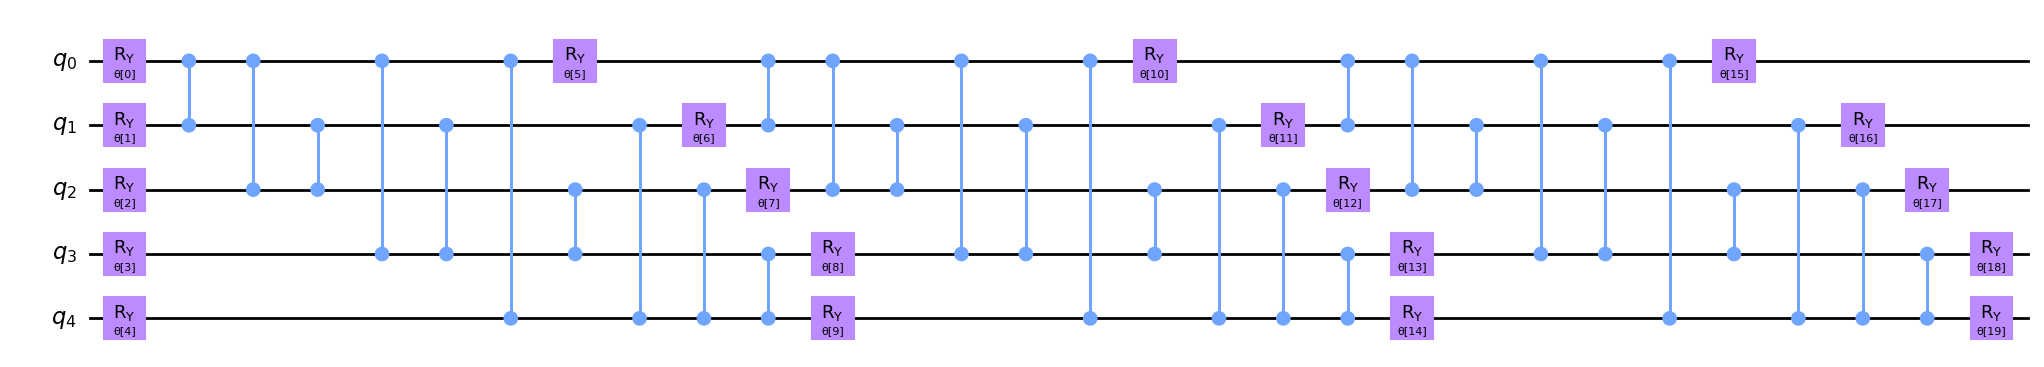

In [5]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
ansatz.decompose().draw('mpl', fold=150)

$\theta$ parameters for this circuit are the ones that need to be trained so that at the end, the solution with highest success probability shows the result to our problem.

In [6]:
from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0]	0.0005		0.3394
[1 0 0 1 0]	0.0016		0.3209
[0 0 1 1 0]	0.0001		0.1498
[0 1 1 0 0]	-0.0010		0.1415
[1 0 0 0 1]	0.0013		0.0319
[0 0 1 0 1]	0.0002		0.0155
[0 0 1 0 0]	1.0074		0.0002
[0 1 1 1 0]	1.0102		0.0001
[1 0 0 0 0]	1.0089		0.0001
[1 0 1 0 1]	1.0090		0.0001
[1 1 0 1 0]	1.0117		0.0001
[0 1 0 0 1]	0.0024		0.0001
[1 0 0 1 1]	1.0127		0.0000
[1 1 1 0 1]	4.0374		0.0000
[0 0 0 0 1]	1.0108		0.0000
[1 0 1 0 0]	-0.0017		0.0000
[0 0 1 1 1]	1.0115		0.0000
[0 1 0 1 0]	0.0024		0.0000
[1 1 1 1 0]	4.0379		0.0000
[1 0 1 1 1]	4.0387		0.0000
[0 0 0 1 1]	0.0038		0.0000
[1 1 1 1 1]	9.0856		0.0000
[0 0 0 0 0]	4.0363		0.0000
[0 1 0 0 0]	1.0095		0.0000
[1 1 1 0 0]	1.0083		0.0000
[1 1 0 0 1]	1.0113		0.0000
[0 1 1 1 1]	4.0400		0.0000
[0 1 0 1 1]	1.0139		0.0000
[1 1 0 1 1]	4.0411		0.0000
[0 1 1 0 1]	1.0101		0.0000
[0 

At this point it is important we pay attention at the probability column. This column states how plausible it is that using this circuit with found parameters we may found the optimal result. Our candidate solution has relativelly low probability, which means we should find better designs to increase our chances. We can easilly test how it would look like by adding more repetitions to the ansatz.

In [7]:
ansatz = TwoLocal(num_assets, "ry", "cz", reps=6, entanglement="full")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0]	-0.0017		0.7700
[1 0 0 1 0]	0.0016		0.0671
[0 0 1 1 0]	0.0001		0.0593
[1 1 0 0 0]	0.0005		0.0274
[0 0 0 1 1]	0.0038		0.0211
[0 1 0 1 0]	0.0024		0.0190
[1 0 0 0 1]	0.0013		0.0174
[0 0 1 0 1]	0.0002		0.0076
[0 1 1 0 0]	-0.0010		0.0061
[0 1 0 0 0]	1.0095		0.0015
[0 1 0 0 1]	0.0024		0.0015
[0 1 1 1 0]	1.0102		0.0008
[1 1 0 1 0]	1.0117		0.0004
[1 1 1 0 0]	1.0083		0.0002
[0 1 1 0 1]	1.0101		0.0002
[0 1 0 1 1]	1.0139		0.0002
[0 0 0 0 1]	1.0108		0.0001
[0 0 0 1 0]	1.0106		0.0001
[1 0 1 0 1]	1.0090		0.0001
[1 0 0 0 0]	1.0089		0.0001
[1 1 1 0 1]	4.0374		0.0000
[1 0 1 1 1]	4.0387		0.0000
[0 0 1 1 1]	1.0115		0.0000
[1 1 0 0 1]	1.0113		0.0000
[0 0 1 0 0]	1.0074		0.0000
[0 0 0 0 0]	4.0363		0.0000
[1 0 1 1 0]	1.0094		0.0000
[1 1 1 1 1]	9.0856		0.0000
[1 1 0 1 1]	4.0411		0.0000
[1 0 0 1 1]	1.0127		0.0000
[1 

Right now we reached 20% chances of seeing this state on a single run of our circuit. We could then simulate lets say for 5 runs so that way we most probably would register classically that state at least once.

In [8]:
best_parameters = None
for key, value in vqe_mes.__dict__.items():
    if key == "_ret":
        best_parameters = value.optimal_parameters

We can try with a different approach, in this case QAOA. For that, only number of layers to repeat the canonical form of the ansatz need to be provided.

In [9]:
from qiskit.algorithms import QAOA

layers = 2
qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1]	0.0038		0.0731
[0 1 0 0 1]	0.0024		0.0729
[0 1 0 1 0]	0.0024		0.0729
[1 0 0 1 0]	0.0016		0.0728
[1 0 0 0 1]	0.0013		0.0728
[1 1 0 0 0]	0.0005		0.0726
[0 0 1 0 1]	0.0002		0.0726
[0 0 1 1 0]	0.0001		0.0726
[0 1 1 0 0]	-0.0010		0.0724
[1 0 1 0 0]	-0.0017		0.0723
[0 1 0 1 1]	1.0139		0.0206
[1 0 0 1 1]	1.0127		0.0204
[1 1 0 1 0]	1.0117		0.0204
[0 0 1 1 1]	1.0115		0.0203
[1 1 0 0 1]	1.0113		0.0203
[0 1 1 1 0]	1.0102		0.0202
[0 1 1 0 1]	1.0101		0.0202
[1 0 1 1 0]	1.0094		0.0202
[1 0 1 0 1]	1.0090		0.0201
[1 1 1 0 0]	1.0083		0.0200
[0 0 0 0 1]	1.0108		0.0123
[0 0 0 1 0]	1.0106		0.0123
[0 1 0 0 0]	1.0095		0.0122
[1 0 0 0 0]	1.0089		0.0122
[0 0 1 0 0]	1.0074		0.0121
[1 1 1 1 1]	9.0856		0.0046
[0 0 0 0 0]	4.0363		0.0013
[1 1 1 0 1]	4.0374		0.0007
[1 1 1 1 0]	4.0379		0.0007
[1 0 1 1 1]	4.0387		0.0007
[0 

In [10]:
layers = 5

qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1]	0.0038		0.0790
[0 1 0 1 0]	0.0024		0.0786
[0 1 0 0 1]	0.0024		0.0785
[1 0 0 0 1]	0.0013		0.0781
[1 0 0 1 0]	0.0016		0.0781
[0 0 1 1 0]	0.0001		0.0775
[1 1 0 0 0]	0.0005		0.0774
[0 0 1 0 1]	0.0002		0.0774
[0 1 1 0 0]	-0.0010		0.0769
[1 0 1 0 0]	-0.0017		0.0763
[0 0 0 1 0]	1.0106		0.0208
[0 0 0 0 1]	1.0108		0.0206
[0 1 0 0 0]	1.0095		0.0205
[1 0 0 0 0]	1.0089		0.0202
[0 0 1 0 0]	1.0074		0.0200
[0 1 0 1 1]	1.0139		0.0107
[1 0 0 1 1]	1.0127		0.0107
[1 1 0 0 1]	1.0113		0.0106
[1 1 0 1 0]	1.0117		0.0105
[0 0 1 1 1]	1.0115		0.0105
[0 1 1 1 0]	1.0102		0.0104
[0 1 1 0 1]	1.0101		0.0104
[1 0 1 0 1]	1.0090		0.0104
[1 0 1 1 0]	1.0094		0.0103
[1 1 1 0 0]	1.0083		0.0102
[0 0 0 0 0]	4.0363		0.0094
[1 1 1 1 1]	9.0856		0.0013
[1 1 1 1 0]	4.0379		0.0010
[0 1 1 1 1]	4.0400		0.0009
[1 1 1 0 1]	4.0374		0.0009
[1 

In this case, the depth of the circuit did not make much in favor of our outcome as the chances of getting the optimal solution decreased from almost 8% to 6%.

In [11]:
layers = 1

qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1]	0.0038		0.0662
[0 1 0 0 1]	0.0024		0.0658
[0 1 0 1 0]	0.0024		0.0658
[1 0 0 1 0]	0.0016		0.0656
[1 0 0 0 1]	0.0013		0.0655
[1 1 0 0 0]	0.0005		0.0654
[0 0 1 0 1]	0.0002		0.0653
[0 0 1 1 0]	0.0001		0.0652
[0 1 1 0 0]	-0.0010		0.0650
[1 0 1 0 0]	-0.0017		0.0649
[0 1 0 1 1]	1.0139		0.0226
[0 0 0 0 1]	1.0108		0.0225
[0 0 0 1 0]	1.0106		0.0224
[1 0 0 1 1]	1.0127		0.0224
[1 1 0 1 0]	1.0117		0.0224
[0 0 1 1 1]	1.0115		0.0223
[0 1 0 0 0]	1.0095		0.0223
[1 0 0 0 0]	1.0089		0.0223
[1 1 0 0 1]	1.0113		0.0223
[0 1 1 1 0]	1.0102		0.0222
[0 1 1 0 1]	1.0101		0.0222
[0 0 1 0 0]	1.0074		0.0221
[1 0 1 1 0]	1.0094		0.0221
[1 0 1 0 1]	1.0090		0.0220
[1 1 1 0 0]	1.0083		0.0220
[1 1 1 1 1]	9.0856		0.0044
[0 0 0 0 0]	4.0363		0.0031
[1 1 1 0 1]	4.0374		0.0008
[1 1 1 1 0]	4.0379		0.0007
[1 0 1 1 1]	4.0387		0.0007
[0 

As it also happends with classical ML and QML approaches, design is key for solving the problem with a high success rate for obtaining the best possible solution. Lets run our best solution up to now and see how the outcome would look like.

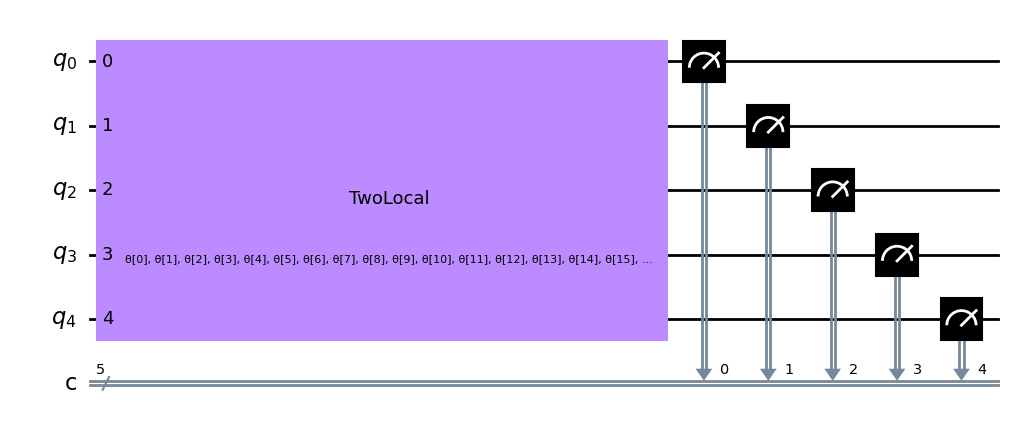

In [12]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(num_assets,num_assets)

# VQE Two Local ansatz
qc.compose(ansatz, inplace=True)

# Measures
for i in range(0, num_assets):
    qc.measure(i, i)

qc.draw('mpl', fold=150)

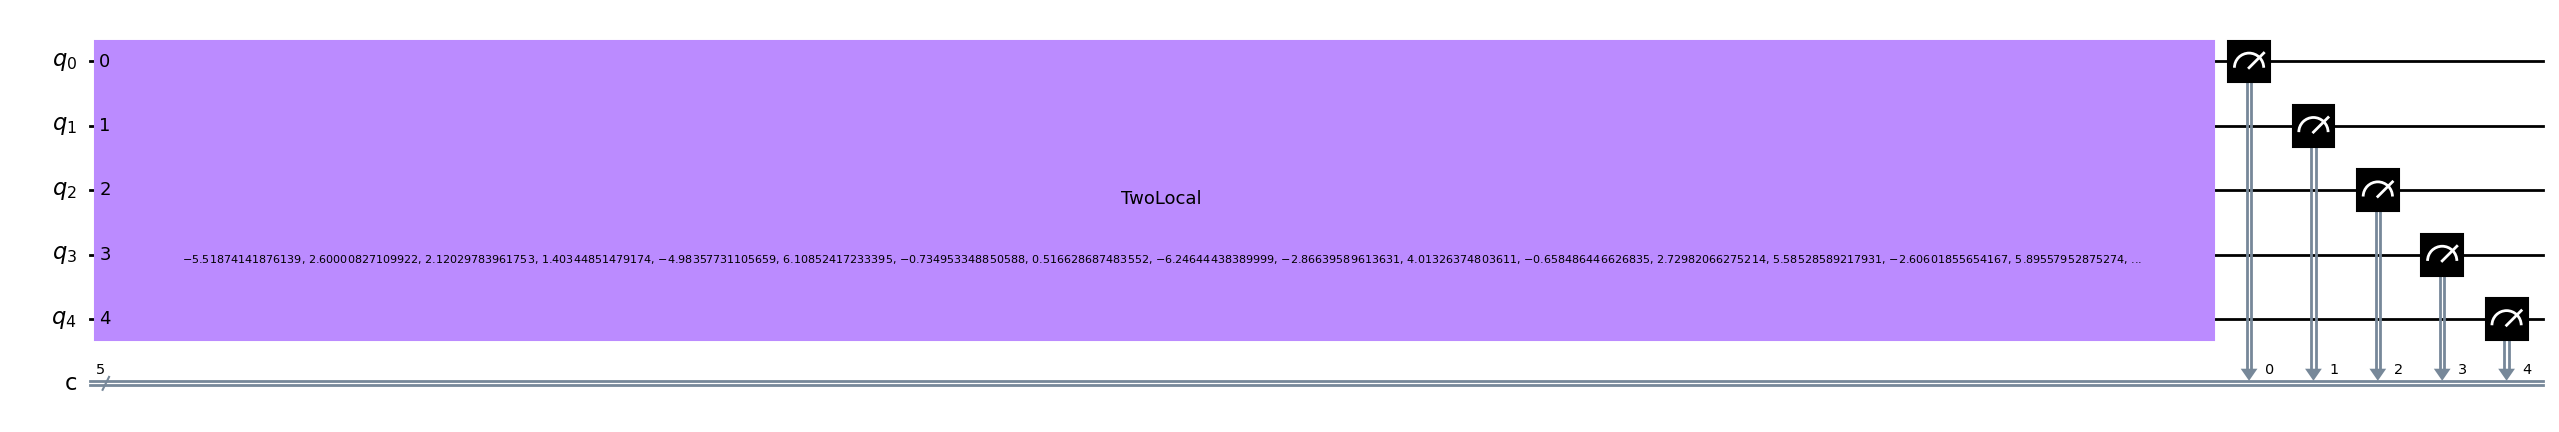

In [13]:
pqc = qc.bind_parameters(best_parameters)
pqc.draw('mpl', fold=150)

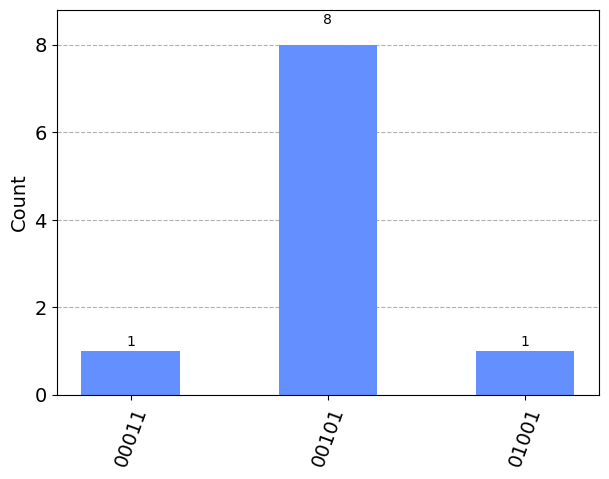

In [14]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

# Number of shots to the circuit
nshots = 10

# execute the quantum circuit
backend = Aer.get_backend('qasm_simulator') # the device to run on
result = execute(pqc, backend, shots=nshots).result()
counts  = result.get_counts(pqc)

plot_histogram(counts)

In [15]:
print("Solutions found:")
for cres in counts:
    print(f"Solution {cres[::-1]} with success probability {counts[cres]*100/nshots}%")

Solutions found:
Solution 10010 with success probability 10.0%
Solution 11000 with success probability 10.0%
Solution 10100 with success probability 80.0%
